In [614]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

# 1. Coleta de dados

In [615]:
df = pd.read_csv('https://raw.githubusercontent.com/marcelovalois/eafifa/main/FIFA-21.csv')

In [616]:
df.head()

,player_id,name,nationality,position,overall,age,hits,potential,team
0,158023,Lionel Messi,Argentina,ST|CF|RW,94,33,299,94,FC Barcelona
1,20801,Cristiano Ronaldo,Portugal,ST|LW,93,35,276,93,Juventus
2,190871,Neymar Jr,Brazil,CAM|LW,92,28,186,92,Paris Saint-Germain
3,203376,Virgil van Dijk,Netherlands,CB,91,29,127,92,Liverpool
4,200389,Jan Oblak,Slovenia,GK,91,27,47,93,Atlético Madrid


### Descrição dos dados

- player_id: o id do jogador no jogo.
- name: O nome do jogador.
- nationality: O país em que o jogador nasceu.
- position: A posição (ou posições) que o jogador atua.
- overall: A média geral do jogador no FIFA.
- age: A idade do jogador.
- potential: O potencial do jogador.
- team: O clube em que ele joga.

# 2. Pré-processamento

## Definição de tipos

In [617]:
df.dtypes

player_id       int64
name           object
nationality    object
position       object
overall         int64
age             int64
hits            int64
potential       int64
team           object
dtype: object

In [618]:
df['name'] = df['name'].astype('category')
df['nationality'] = df['nationality'].astype('category')
df['position'] = df['position'].astype('category')
df['team'] = df['team'].astype('category')

In [619]:
df.dtypes

player_id         int64
name           category
nationality    category
position       category
overall           int64
age               int64
hits              int64
potential         int64
team           category
dtype: object

## Tratamento de dados ausentes

In [620]:
df.shape

(17981, 9)

São listados os jogadores do Real Madrid com overall menor que 65, com o intuito de desconsiderar seus valores. São jogadores que abaixam o overall médio do time mas que nunca veem jogo.

In [621]:
df.loc[(df['overall'] < 65) & (df['team'] == 'Real Madrid ')]

,player_id,name,nationality,position,overall,age,hits,potential,team
13140,247411,Altube,Spain,GK,63,20,8,80,Real Madrid
13165,246606,Fran García,Spain,LB|LW,63,20,2,78,Real Madrid


In [622]:
df.loc[(df['overall'] < 65) & (df['team'] == 'Real Madrid '), ['overall']] = np.nan

In [623]:
print(df.isnull().sum())

player_id      0
name           0
nationality    0
position       0
overall        2
age            0
hits           0
potential      0
team           0
dtype: int64


É feita imputação de dados com a mediana

In [624]:
realMadridMean = df[df['team'] == 'Real Madrid ']['overall'].median()
realMadridMean

82.0

In [625]:
df['overall'].fillna(realMadridMean, inplace=True)

In [626]:
df[df['team'] == 'Real Madrid ']['overall']


7        91.0
17       89.0
18       89.0
21       89.0
26       88.0
28       88.0
31       88.0
68       86.0
94       85.0
98       85.0
109      85.0
135      84.0
151      84.0
226      82.0
229      82.0
250      82.0
277      82.0
289      82.0
316      81.0
329      81.0
469      80.0
562      79.0
735      78.0
806      78.0
2240     74.0
3358     72.0
4288     71.0
6037     69.0
9430     66.0
9448     66.0
10743    65.0
13140    82.0
13165    82.0
Name: overall, dtype: float64

## Normalização e limpeza

In [627]:
scaler = MinMaxScaler()
df['overall_norm'] = scaler.fit_transform(df[['overall']])
df['overall_norm'].describe()

count    17981.000000
mean         0.296749
std          0.155954
min          0.000000
25%          0.184211
50%          0.289474
75%          0.394737
max          1.000000
Name: overall_norm, dtype: float64

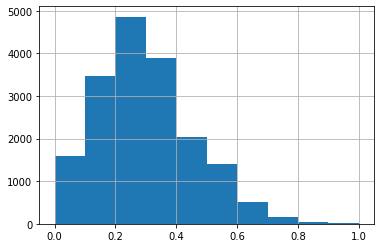

In [628]:
df['overall_norm'].hist()

In [629]:
q1 = df['overall_norm'].quantile(q=0.25)
q3 = df['overall_norm'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)

0.21052631578947367


In [630]:
df[df['overall_norm'] > (q3+1.5*iqr)]

,player_id,name,nationality,position,overall,age,hits,potential,team,overall_norm
0,158023,Lionel Messi,Argentina,ST|CF|RW,94.0,33,299,94,FC Barcelona,1.000000
1,20801,Cristiano Ronaldo,Portugal,ST|LW,93.0,35,276,93,Juventus,0.973684
2,190871,Neymar Jr,Brazil,CAM|LW,92.0,28,186,92,Paris Saint-Germain,0.947368
3,203376,Virgil van Dijk,Netherlands,CB,91.0,29,127,92,Liverpool,0.921053
4,200389,Jan Oblak,Slovenia,GK,91.0,27,47,93,Atlético Madrid,0.921053
...,...,...,...,...,...,...,...,...,...,...
218,163705,Steve Mandanda,France,GK,83.0,35,4,83,Olympique de Marseille,0.710526
219,163587,Kasper Schmeichel,Denmark,GK,83.0,33,41,83,Leicester City,0.710526
220,157481,Raúl Albiol,Spain,CB,83.0,34,7,83,Villarreal CF,0.710526
221,146562,Santi Cazorla,Spain,CDM|LM|CM,83.0,35,22,83,Villarreal CF,0.710526


## Discretização

É feita a discritização com 5 bins com mesmo intervalo

In [631]:
df['potential_dist'] = pd.cut(df['potential'], 5)

In [632]:
df['potential_dist'].value_counts()

(64.6, 72.2]      8325
(72.2, 79.8]      5832
(56.962, 64.6]    1913
(79.8, 87.4]      1788
(87.4, 95.0]       123
Name: potential_dist, dtype: int64

In [633]:
df['potential_dist'].describe()

count            17981
unique               5
top       (64.6, 72.2]
freq              8325
Name: potential_dist, dtype: object

# 3. Estatísticas descritivas com visualizações

In [634]:
df.describe()

,player_id,overall,age,hits,potential,overall_norm
count,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000
mean,220912.660531,67.276458,26.311440,2.689450,71.738057,0.296749
std,27738.072671,5.926256,4.556077,10.846286,5.961968,0.155954
min,41.000000,56.000000,17.000000,0.000000,57.000000,0.000000
25%,204881.000000,63.000000,23.000000,0.000000,67.000000,0.184211
50%,226753.000000,67.000000,26.000000,0.000000,71.000000,0.289474
75%,241587.000000,71.000000,30.000000,2.000000,76.000000,0.394737
max,256469.000000,94.000000,43.000000,371.000000,95.000000,1.000000


In [635]:
numero_de_paises = df['nationality'].nunique()
numero_de_paises

162

In [636]:
top_paises = df['nationality'].value_counts().head(20)

top_paises

England           1496
Germany           1138
Spain             1055
Argentina          970
France             948
Brazil             894
Italy              637
Colombia           561
Japan              448
Netherlands        418
Uruguay            352
Portugal           351
Mexico             329
Chile              318
Austria            306
Norway             293
Korea Republic     286
Poland             283
United States      282
Denmark            275
Name: nationality, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


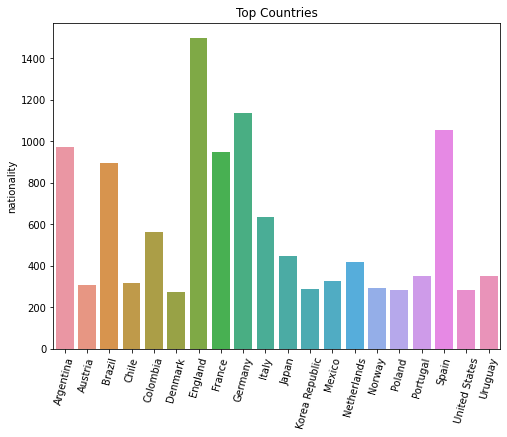

In [637]:
top_paises = df['nationality'].value_counts().head(20)
plt.figure(figsize=(8,6))
plt.xticks(rotation=75)
plt.title("Top Countries")
sns.barplot(top_paises.index.remove_unused_categories(), top_paises)

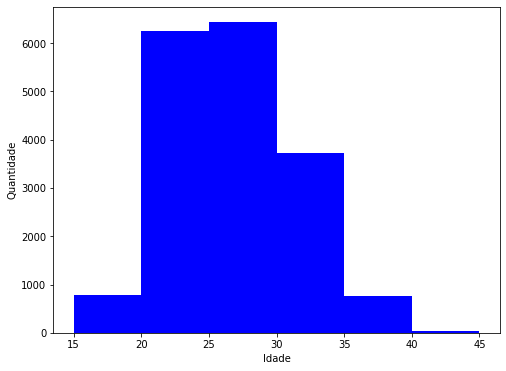

In [638]:
plt.figure(figsize=(8, 6))

plt.xlabel('Idade')
plt.ylabel('Quantidade')

plt.hist(df['age'], bins=np.arange(15,50,5), color='blue');

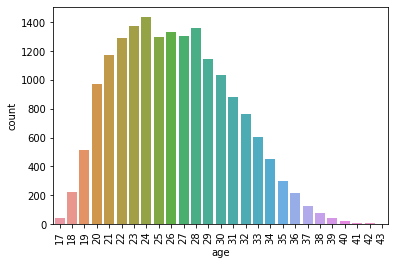

In [639]:
sns.countplot(x=df['age'])
plt.xticks(rotation=90);

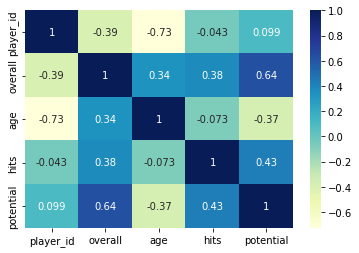

In [640]:
df = df.drop('overall_norm', axis=1)
sns.heatmap(data=df.corr(), cmap="YlGnBu", annot=True)


# 4. Teste de Hipótese

H0: Jogadores brasileiros têm overall semelhante ao dos franceses.
H1: Jogadores brasileiros são melhores (têm mais overall) que jogadores franceses?

In [641]:
def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.12f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

In [642]:
def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    print("p value:%.12f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")

In [643]:
jogadores_brasileiros = df[df['nationality'] == 'Brazil']['overall']
jogadores_franceses = df[df['nationality'] == 'France']['overall']

In [644]:
jogadores_brasileiros.count()

894

In [645]:
jogadores_franceses.count()

948

In [646]:
check_normality(jogadores_brasileiros)

p value:0.000003308748
Reject null hypothesis >> The data is not normally distributed


In [647]:
check_normality(jogadores_franceses)

p value:0.000000000047
Reject null hypothesis >> The data is not normally distributed


In [648]:
check_variance_homogeneity(jogadores_brasileiros, jogadores_franceses)

p value:0.000000000031
Reject null hypothesis >> The variances of the samples are different.


In [649]:
ttest,pvalue = stats.mannwhitneyu(jogadores_brasileiros,jogadores_franceses, alternative="two-sided")
print("p-value:%.4f" % pvalue)
if pvalue <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p-value:0.0000
Reject null hypothesis


Aqui é possível observar que os brasileiros têm overall maior que os franceses

